# IST 652: Final Project
### Patty Meadows, Jon Durbin

### Table of Contents
1. [Data Importing/Cleaning](#importclean)
1. [Questions](#questions)
    1. [Average Runtime](#avgruntime)
    1. [What is the Count of Actors and Directors per Platform?](#countactorsdirs)
    1. [Distribution of Genres](#distgenre)
    1. [Average TMDB and IMDB Score per Genre](#avgtmdb)
    1. [What is the Distribution of Movies and TV Shows Per Platform?](#distshowsmovies)
    1. [TMDB and IMDB Score Distribution](#imdbscoredist)
    1. [Average TMDB and IMDB Score Per Platform](#tmdbscoreperplatform)
1. [Sources](#sources)

## Data Importing/Cleaning <a name="importclean"></a>

In [1]:
import pathlib
import pandas as pd
import csv
import re

import matplotlib
import matplotlib.pyplot as plot

In [2]:
# data in raw folder is exactly how it was downloaded - all changes made to it go in the cleaned folder

raw_data_path = pathlib.Path('data/raw')
cleaned_data_path = pathlib.Path('data/cleaned')

We create some regex patterns that we can use to read in the csv files. The files have "good" and "bad" rows. These regular expressions will ignore the "bad" rows.

In [3]:
titles_pattern = re.compile(
    r'''
    ^(\w*),             # id
    (\"?.*\"?),         # title
    (MOVIE|SHOW),       # type
    (\"?.*\"?),         # description
    (\d{4}?),           # release_year
    ([\w-]*?),          # age_certification
    (\d*),              # runtime
    (\"?[a-z\[\]\-\"\',\s]*\"?),   # genres
    (\"?[A-Z\[\]\-\"\',\s]*\"?),   # production_countries
    ([\d.]*),           # seasons
    (\w*),              # imdb_id
    ([\d.]*),           # imdb_score
    ([\d.]*),           # imdb_votes
    ([\d.]*),           # tmdb_popularity
    ([\d.]*)$           # tmdb_score
    ''',
    re.X
)

credits_pattern = re.compile(
    r'''
    ^(\w*),  # person_id
    (\w*),   # id
    (.*),    # name
    (.*),    # character
    (\w*)$   # role
    ''',
    re.X
)

Below, we iterate through all of the files in the raw folder, remove any bad characters, then re-write them to the clean folder.

In [4]:
credits_header = 'person_id,id,name,character,role,platform'
titles_header = 'id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform'

for folder in raw_data_path.iterdir():
    for file in folder.iterdir():
        rows = []
        with open(file, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f.readlines()):
                if i == 0: continue
                new_row = []
                if file.stem == 'titles':
                    m = re.search(titles_pattern, line)
                    if m:
                        cols = {
                            1: m[1].replace('"', ''),
                            2: m[2].replace('"', '').replace(',', ''),
                            3: m[3].replace('"', ''),
                            4: m[4].replace('"', '').replace(',', ''),
                            5: m[5].replace('"', ''),
                            6: m[6].replace('"', ''),
                            7: m[7].replace('"', ''),
                            8: m[8].replace('"', '').replace('[', '').replace(']', '').replace("'", '').replace(',', '|').replace(' ', ''),
                            9: m[9].replace('"', '').replace('[', '').replace(']', '').replace("'", '').replace(',', '|').replace(' ', ''),
                            10: m[10].replace('"', ''),
                            11: m[11].replace('"', ''),
                            12: m[12].replace('"', ''),
                            13: m[13].replace('"', ''),
                            14: m[14].replace('"', ''),
                            15: m[15].replace('"', ''),
                        }
                else:
                    m = re.search(credits_pattern, line)
                    if m:
                        cols = {
                            1: m[1],
                            2: m[2].replace('"', '').replace(',', ''),
                            3: m[3].replace('"', '').replace(',', ''),
                            4: m[4].replace('"', '').replace(',', ''),
                            5: m[5],
                        }
                new_row = ','.join([cols[i] for i in cols.keys()] + [folder.name])
                rows.append(new_row)

        clean_path = cleaned_data_path.joinpath(folder.name)
        # try creating the directory, just in case
        clean_path.mkdir(exist_ok=True)
        print(f'writing to {clean_path}\\{file.name}')
        with open(f'{clean_path}\\{file.name}', 'w', encoding='utf-8') as f:
            if file.stem == 'titles':
                f.write('\n'.join([titles_header] + list(set(rows))))
            else:
                f.write('\n'.join([credits_header] + list(set(rows))))

writing to data\cleaned\amazon prime\credits.csv
writing to data\cleaned\amazon prime\titles.csv
writing to data\cleaned\disney\credits.csv
writing to data\cleaned\disney\titles.csv
writing to data\cleaned\hbo max\credits.csv
writing to data\cleaned\hbo max\titles.csv
writing to data\cleaned\hulu tv\credits.csv
writing to data\cleaned\hulu tv\titles.csv
writing to data\cleaned\netflix\credits.csv
writing to data\cleaned\netflix\titles.csv
writing to data\cleaned\paramount\credits.csv
writing to data\cleaned\paramount\titles.csv


In [5]:
# build a massive data dictionary of all of the datasets

data = {}

for folder in cleaned_data_path.iterdir():
    for file in folder.iterdir():
        data[f'{folder.name}/{file.name}'] = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')

# concatenate the datasets that are relevant to each other

credits = pd.concat([data[i] for i in data.keys() if 'credits' in i])
titles = pd.concat([data[i] for i in data.keys() if 'titles' in i])

In [6]:
credits.head(4)

,person_id,id,name,character,role,platform
0,200486,tm230558,Lena Owens,Divine,ACTOR,amazon prime
1,157063,tm214169,Danielle Lauder,Emily Turner,ACTOR,amazon prime
2,881120,tm95163,Jesús Luque,Aristander (as Jesus Luque),ACTOR,amazon prime
3,14967,ts21182,Corbin Bernsen,Henry Spencer,ACTOR,amazon prime


In [7]:
titles.head(4)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,platform
0,tm452832,Azeem Banatwalla: Problems,MOVIE,Azeem Banatwalla's second stand-up special is ...,2019,NaN,67,comedy,IN,NaN,tt9569212,7.8,296.0,1.005,6.8,amazon prime
1,tm999311,Donna: Stronger Than Pretty,MOVIE,A young mother's American Dream turns into a l...,2021,NaN,110,drama,US,NaN,tt14532328,6.3,509.0,1.353,4.5,amazon prime
2,tm466668,The End of the Road,MOVIE,In Peru Sergio García Locatelli visits both th...,2015,NaN,40,documentation,PE,NaN,tt5341716,NaN,NaN,0.600,4.0,amazon prime
3,tm115888,Revolt of the Zombies,MOVIE,The story is set in Cambodia in the years foll...,1936,NaN,65,horror,US,NaN,tt0028174,3.4,1693.0,2.739,3.3,amazon prime


In [8]:
# confirm that data from each of the six platforms is present

titles.platform.unique(), credits.platform.unique()

(array(['amazon prime', 'disney', 'hbo max', 'hulu tv', 'netflix',
        'paramount'], dtype=object),
 array(['amazon prime', 'disney', 'hbo max', 'hulu tv', 'netflix',
        'paramount'], dtype=object))

1. average runtime per platform
1. distribution of genres
1. distribution between tv/movies
1. average tmdb score per genre
1. count of actor and director per platform
1. average tmdb score for each person
1. imdb score distribution

## Questions <a name="questions"></a>

### Question 1: Average runtime per platform <a name="avgruntime"></a>

In [9]:
Q1 = titles.groupby("platform").agg(
    avg_runtime = ("runtime","mean")
).round(1).sort_values(by=["avg_runtime"])

Q1

,avg_runtime
platform,
disney,60.4
hulu tv,62.6
paramount,72.9
netflix,77.2
hbo max,81.4
amazon prime,86.6


<AxesSubplot:title={'center':'Average Runtime (in minutes) per Platform'}, ylabel='platform'>

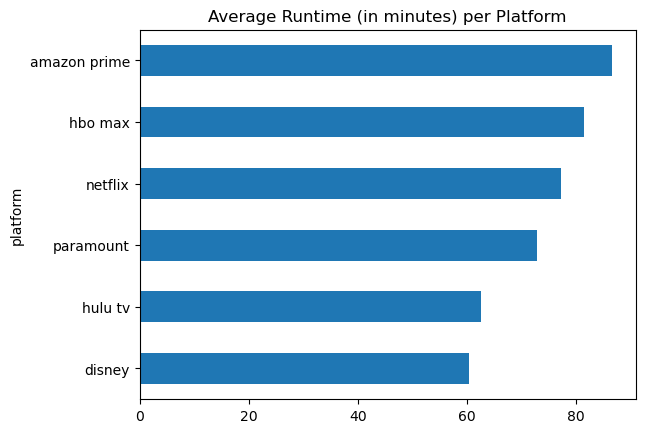

In [10]:
Q1.plot.barh(title="Average Runtime (in minutes) per Platform",legend=False)

### Question 2: What is the Count of Actors and Directors per Platform? <a name="countactorsdirs"></a>

In [11]:
Q5Actors = credits[credits["role"]=="ACTOR"]
Q5Actors = Q5Actors.groupby(["platform"]).agg(Actors = ("person_id", "count")).sort_values(by=["Actors"])
print(Q5Actors)

print()

Q5Directors = credits[credits["role"]=="DIRECTOR"]
Q5Directors = Q5Directors.groupby(["platform"]).agg(Directors = ("person_id", "count")).sort_values(by=["Directors"])
print(Q5Directors)

print()

WhoIsWho = pd.merge(Q5Actors,
                    Q5Directors["Directors"],
                    on="platform")

print(WhoIsWho)


              Actors
platform            
disney         25060
hulu tv        30448
paramount      37664
hbo max        63619
netflix        73251
amazon prime  115793

              Directors
platform               
disney             1352
hulu tv            1354
paramount          2178
hbo max            2774
netflix            4550
amazon prime       8386

              Actors  Directors
platform                       
disney         25060       1352
hulu tv        30448       1354
paramount      37664       2178
hbo max        63619       2774
netflix        73251       4550
amazon prime  115793       8386


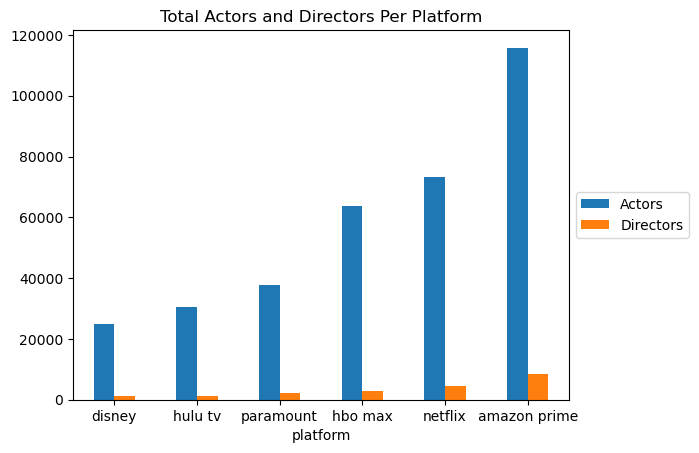

In [12]:
WhoIsWho.plot.bar(
    rot=0, 
    title = "Total Actors and Directors Per Platform"
).legend(
    loc='center left', 
    bbox_to_anchor=(1,0.5)
)


### Question 3: Distribution of genres. <a name="distgenre"></a>

In [13]:
gens = {}

for i, row in titles.iterrows():
    if pd.isna(row['genres']):
        gens['no genre'] = gens.get('no genre', 0) + 1
        continue
    for g in row['genres'].split('|'):
        gens[g] = gens.get(g, 0) + 1

for gen, cnt in sorted(gens.items(), key = lambda i: i[1], reverse=True):
    print(f'{gen: <14}: {cnt}')

drama         : 11608
comedy        : 8867
thriller      : 5011
action        : 4833
romance       : 4241
documentation : 3925
crime         : 3433
family        : 2975
scifi         : 2580
animation     : 2506
fantasy       : 2495
horror        : 2193
european      : 1804
music         : 1180
history       : 1090
western       : 855
reality       : 799
war           : 773
sport         : 693
no genre      : 423


### Question 4: Average TMDB and IMDB Score per Genre <a name="avgtmdb"></a>

In [14]:
tmdb_scores = {}

for i, row in titles.iterrows():
    if pd.isna(row['genres']) or pd.isna(row['tmdb_score']):
        continue
    for genre in row['genres'].split('|'):
        tmdb_scores[genre] = tmdb_scores.get(genre, []) + [row['tmdb_score']]
        
tmdb_scores_avg = {}
for gen, ls in sorted(tmdb_scores.items(), key = lambda i: i[1], reverse=True):
    tmdb_scores_avg[gen] = sum(ls)/len(ls)


for gen, n in sorted(tmdb_scores_avg.items(), key = lambda i: i[1], reverse=True):
    print(f'{gen: <14}: {n:.2f}')

animation     : 7.17
reality       : 7.15
documentation : 6.93
history       : 6.91
family        : 6.82
fantasy       : 6.79
scifi         : 6.65
war           : 6.65
sport         : 6.63
music         : 6.55
drama         : 6.52
european      : 6.52
crime         : 6.49
comedy        : 6.46
action        : 6.43
romance       : 6.36
thriller      : 6.21
horror        : 5.78
western       : 5.66


### Question 5: What is the Distribution of Movies and TV Shows Per Platform <a name="distshowsmovies"></a>

In [15]:
#Looking at the unique values in the type column of the titles DF
titles.type.unique()

array(['MOVIE', 'SHOW'], dtype=object)

In [16]:
#Making a sub dataframes for each platform

AmazonDF = pd.DataFrame((titles[titles["platform"]=="amazon prime"]), columns=["type","platform","release_year"])
DisneyDF = pd.DataFrame((titles[titles["platform"]=="disney"]), columns=["type","platform","release_year"])
HBOMaxDF = pd.DataFrame((titles[titles["platform"]=="hbo max"]), columns=["type","platform","release_year"])
HuluDF = pd.DataFrame((titles[titles["platform"]=="hulu tv"]), columns=["type","platform","release_year"])
NetflixDF = pd.DataFrame((titles[titles["platform"]=="netflix"]), columns=["type","platform","release_year"])
ParamountDF = pd.DataFrame((titles[titles["platform"]=="paramount"]), columns=["type","platform","release_year"])

In [17]:
def movieVStv(platform, ls):
    MovieCount=0
    TVCount=0 
    for x in ls: 
        if x == "MOVIE": 
            MovieCount += 1
        elif x == "SHOW":
            TVCount += 1
        elif x != "MOVIE" or "SHOW":
            continue 
    response=f"{platform: <10}: There are {MovieCount} movies and {TVCount} TV Shows"
    return response
        

In [18]:
print(movieVStv('Amazon', AmazonDF["type"]))
print(movieVStv('Disney +', DisneyDF["type"]))
print(movieVStv('HBO Max', HBOMaxDF["type"]))
print(movieVStv('Hulu', HuluDF["type"]))
print(movieVStv('Netflix', NetflixDF["type"]))
print(movieVStv('Paramount', ParamountDF["type"]))

Amazon    : There are 8501 movies and 1244 TV Shows
Disney +  : There are 1116 movies and 401 TV Shows
HBO Max   : There are 2537 movies and 728 TV Shows
Hulu      : There are 1068 movies and 1251 TV Shows
Netflix   : There are 3741 movies and 2057 TV Shows
Paramount : There are 2198 movies and 588 TV Shows


In [19]:
Q3Data = {
    'platform':['amazon prime', 'disney', 'hbo max', 'hulu tv', 'netflix','paramount'],
    'Movie Count':[8497,1116,2535,1068,3740,2198], 
    "TV Show Count":[1244,401,728,1250,2055,588]
}
Q3DF=pd.DataFrame(Q3Data)
Q3DF=Q3DF.set_index("platform")
Q3DF

,Movie Count,TV Show Count
platform,,
amazon prime,8497,1244
disney,1116,401
hbo max,2535,728
hulu tv,1068,1250
netflix,3740,2055
paramount,2198,588


<AxesSubplot:title={'center':'Movies vs TV Show Counts per Platform'}, xlabel='platform'>

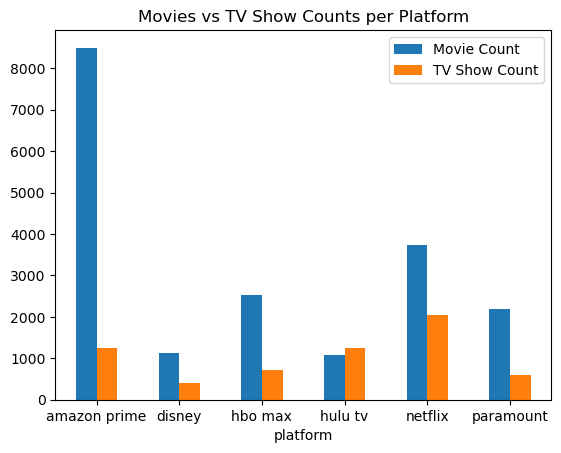

In [20]:
Q3DF.plot.bar(rot=0, title = "Movies vs TV Show Counts per Platform")

In [21]:
print(titles.release_year.unique())
print()
print("Min",titles.release_year.min())
print()
print("Max",titles.release_year.max())

[2019 2021 2015 1936 2016 2017 1944 2006 2001 1993 2008 2020 1995 1979
 2013 1955 2005 1943 1991 1954 1941 1939 2010 1969 2018 2011 2014 1942
 1988 1959 2009 1931 2012 1970 1997 1973 1946 1945 1996 1929 1948 1962
 1938 1967 1964 1990 1987 1940 1980 1985 1994 1984 2022 1999 1972 2004
 2007 1966 2000 1998 1932 1981 1963 1950 1937 1952 1960 1949 1977 1953
 1958 2003 1933 1976 1989 1992 1915 1971 1934 2002 1935 1982 1918 1975
 1974 1947 1983 1968 1986 1956 1965 1924 1930 1961 1926 1912 1978 1920
 1927 1928 1957 1925 1923 1951 1921 1922 1917 1919 1914 1916 1906 1902
 1904 1909 1903 1901]

Min 1901

Max 2022


In [22]:
def DecadesCount(ls,provider):
    Nineteen = 0
    Nineteen10s = 0
    Nineteen20s = 0
    Nineteen30s = 0
    Nineteen40s = 0
    Nineteen50s = 0
    Nineteen60s = 0
    Nineteen70s = 0
    Nineteen80s = 0
    Nineteen90s = 0
    Twenty = 0
    Twenty10s = 0
    Twenty20s = 0
    for x in ls: 
        if x >=1900 and x<=1909: 
            Nineteen += 1
        elif x >=1910 and x<=1919:
            Nineteen10s += 1
        elif x >=1920 and x<=1929: 
            Nineteen20s += 1
        elif x >=1930 and x<=1939: 
            Nineteen30s += 1
        elif x >=1940 and x<=1949: 
            Nineteen40s += 1
        elif x >=1950 and x<=1959:
            Nineteen50s += 1
        elif x >=1960 and x<=1969: 
            Nineteen60s += 1
        elif x >=1970 and x<=1979: 
            Nineteen70s += 1
        elif x >=1980 and x<=1989: 
            Nineteen80s += 1
        elif x >=1990 and x<=1999: 
            Nineteen90s += 1
        elif x >=2000 and x<=2009: 
            Twenty += 1
        elif x >=2010 and x<=2019: 
            Twenty10s += 1
        elif x >=2020 and x<=2029: 
            Twenty20s += 1
         
    response={
        'Year':[
            "1900-1909","1910-1919","1920-1929",
            "1930-1939","1940-1949","1950-1959",
            "1960-1969","1970-1979","1980-1989",
            "1990-1999","2000-2009","2010-2019","2020-2029"
        ],
        'Counts':[
            Nineteen,Nineteen10s,Nineteen20s,Nineteen30s,
            Nineteen40s,Nineteen50s,Nineteen60s,Nineteen70s,
            Nineteen80s,Nineteen90s,Twenty,Twenty10s,Twenty20s
        ]
    }
    responseDF = pd.DataFrame(response)\
        .set_index("Year")\
        .rename(columns={"Counts":provider})
    
    return responseDF

In [23]:
AmazonCntsDF = DecadesCount(AmazonDF["release_year"],"Amazon Counts")
print(AmazonCntsDF)
print()
DisneyCntsDF = DecadesCount(DisneyDF["release_year"],"Disney Counts")
print(DisneyCntsDF)
print()
HBOCntsDF = DecadesCount(HBOMaxDF["release_year"],"HBO Max Counts")
print(HBOCntsDF)
print()
HuluCntsDF = DecadesCount(HuluDF["release_year"],"Hulu Counts")
print(HuluCntsDF)
print()
NetflixCntsDF = DecadesCount(NetflixDF["release_year"],"Netflix Counts")
print(NetflixCntsDF)
print()
ParamountCntsDF = DecadesCount(ParamountDF["release_year"],"Paramount Counts")
print(ParamountCntsDF)

           Amazon Counts
Year                    
1900-1909              0
1910-1919             20
1920-1929             65
1930-1939            414
1940-1949            420
1950-1959            252
1960-1969            236
1970-1979            354
1980-1989            402
1990-1999            533
2000-2009           1147
2010-2019           4274
2020-2029           1628

           Disney Counts
Year                    
1900-1909              0
1910-1919              0
1920-1929              1
1930-1939             35
1940-1949             42
1950-1959             51
1960-1969             28
1970-1979             39
1980-1989             54
1990-1999            136
2000-2009            280
2010-2019            555
2020-2029            296

           HBO Max Counts
Year                     
1900-1909               8
1910-1919              12
1920-1929              37
1930-1939              59
1940-1949              69
1950-1959              96
1960-1969             123
1970-1979     

In [24]:
FullCntDF = pd.merge(AmazonCntsDF,
                    DisneyCntsDF["Disney Counts"],
                    on="Year")

FullCntDF = pd.merge(FullCntDF,
                    HBOCntsDF["HBO Max Counts"],
                    on="Year")

FullCntDF = pd.merge(FullCntDF,
                    HuluCntsDF["Hulu Counts"],
                    on="Year")

FullCntDF = pd.merge(FullCntDF,
                    NetflixCntsDF["Netflix Counts"],
                    on="Year")

FullCntDF = pd.merge(FullCntDF,
                    ParamountCntsDF["Paramount Counts"],
                    on="Year")

FullCntDF 

,Amazon Counts,Disney Counts,HBO Max Counts,Hulu Counts,Netflix Counts,Paramount Counts
Year,,,,,,
1900-1909,0,0,8,0,0,0
1910-1919,20,0,12,0,0,16
1920-1929,65,1,37,0,0,50
1930-1939,414,35,59,0,0,225
1940-1949,420,42,69,0,1,241
1950-1959,252,51,96,1,5,127
1960-1969,236,28,123,3,8,116
1970-1979,354,39,116,9,18,130
1980-1989,402,54,157,34,51,148


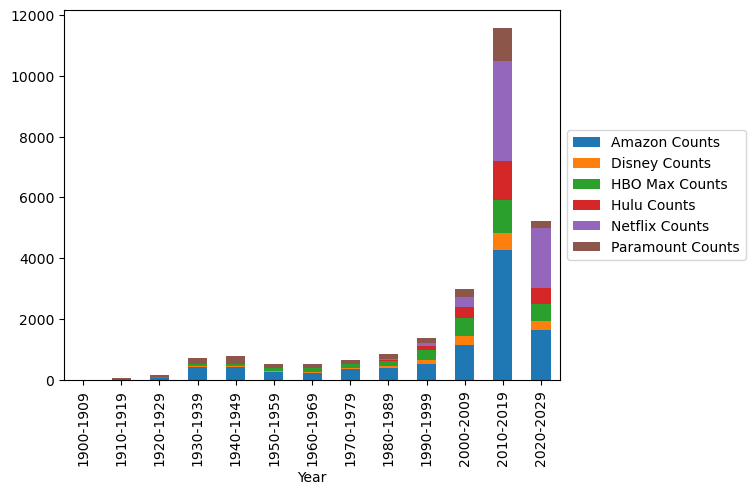

In [25]:
FullCntDF.plot.bar(subplots=False, stacked=True).legend(loc='center left', bbox_to_anchor=(1,0.5))


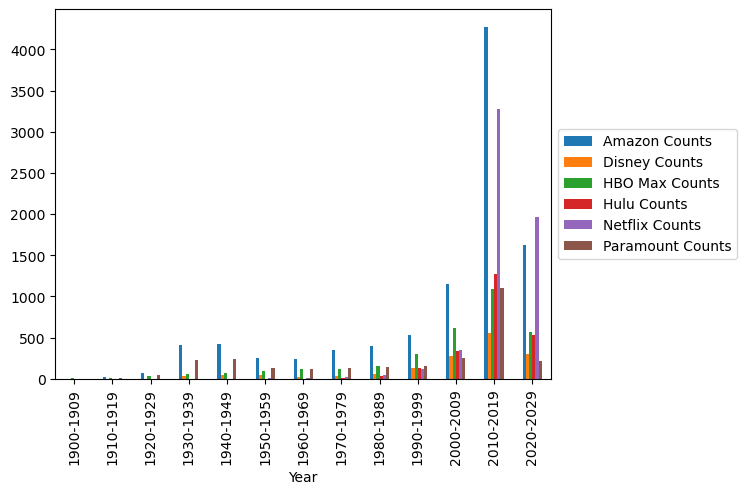

In [26]:
FullCntDF.plot.bar(subplots=False).legend(loc='center left', bbox_to_anchor=(1,0.5))


### Question 6: TMDB and IMDB Score Distribution <a name="imdbscoredist"></a>

array([[<AxesSubplot:title={'center':'imdb_score'}>]], dtype=object)

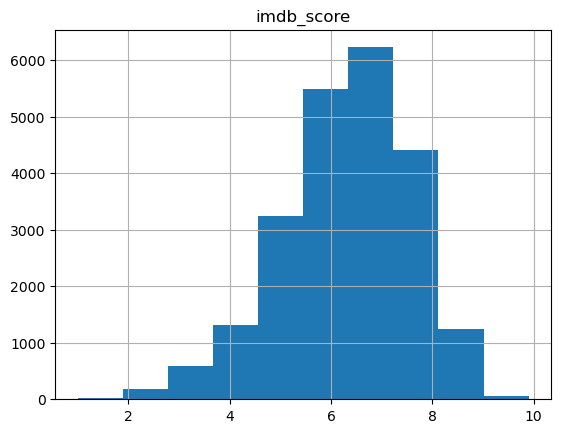

In [27]:
titles.hist(column='imdb_score')

### Question 7: Average TMDB and IMDB Score Per Platform <a name="tmdbscoreperplatform"></a>

In [28]:
Q7 = titles.groupby("platform").agg(
    avg_IMBD = ("imdb_score","mean"),
    avg_TMBD = ("tmdb_score", "mean")).round(1).sort_values(by=["platform"])

Q7

,avg_IMBD,avg_TMBD
platform,,
amazon prime,6.0,6.0
disney,6.6,6.9
hbo max,6.9,6.8
hulu tv,6.7,6.9
netflix,6.5,6.8
paramount,6.0,6.0


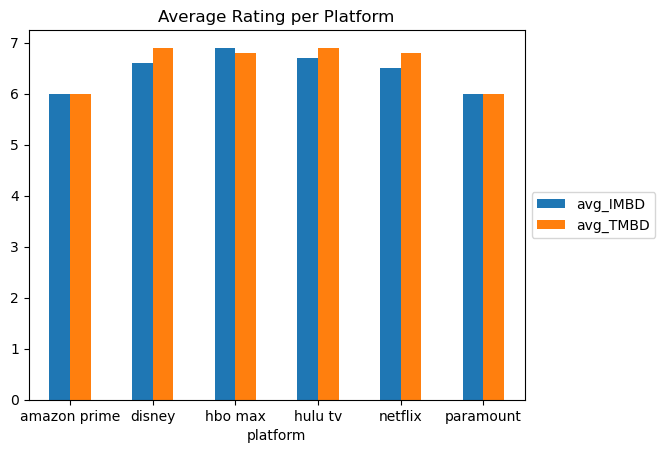

In [29]:
Q7.plot.bar(rot=0, title = "Average Rating per Platform").legend(loc='center left', bbox_to_anchor=(1,0.5))

## Sources <a name="sources"></a>

Data taken from:

1. https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies
1. https://www.kaggle.com/datasets/victorsoeiro/amazon-prime-tv-shows-and-movies
1. https://www.kaggle.com/datasets/victorsoeiro/disney-tv-shows-and-movies
1. https://www.kaggle.com/datasets/victorsoeiro/hbo-max-tv-shows-and-movies
1. https://www.kaggle.com/datasets/victorsoeiro/hulu-tv-shows-and-movies
1. https://www.kaggle.com/datasets/victorsoeiro/paramount-tv-shows-and-movies